### Libraries

In [97]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [98]:
DATA_DIR = r"D:\cell_images_small"
BATCH_SIZE = 32

### Data Transformation

In [99]:
def getTransforms():
    trainTransform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    
    evalTransform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return trainTransform, evalTransform

### Spliting the dataset (70/15/15)

In [100]:
def splitDataset(dataset, random_state=42):
    baseDataset = datasets.ImageFolder(root=dataset,transform=None)

    indices = list(range(len(baseDataset)))
    targets = baseDataset.targets

    trainIdx, tempIdx = train_test_split(indices, test_size=0.3, random_state=random_state, stratify=targets)

    tempTargets = [targets[i] for i in tempIdx]
    valIdx, testIdx = train_test_split(tempIdx, test_size=0.5, random_state=random_state, stratify=tempTargets)

    return trainIdx, valIdx, testIdx

### Create Dataloaders Pipeline

In [101]:
def getDataloaders(dataset):
    trainTransform, evalTransform = getTransforms()
    trainIdx, valIdx, testIdx = splitDataset(dataset)

    trainFull = datasets.ImageFolder(dataset, transform=trainTransform)
    evalFull = datasets.ImageFolder(dataset, transform=evalTransform)

    trainDataset = Subset(trainFull, trainIdx)
    valDataset = Subset(evalFull, valIdx)
    testDataset = Subset(evalFull, testIdx)

    trainLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True) 
    valLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=False)
    testLoader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=False)

    return trainLoader, valLoader, testLoader

### Loading the Data

In [102]:
trainLoader, valLoader, testLoader = getDataloaders(DATA_DIR)

print("Train batches: ", len(trainLoader))
print("Validation batches: ", len(valLoader))
print("Test batches: ", len(testLoader))

Train batches:  5
Validation batches:  1
Test batches:  1


### Models

In [103]:
def get_model(model_name):
    
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
        
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 2)
        
    elif model_name == "vgg19":
        model = models.vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 2)
        
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
        
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
        
    return model

### Training Function

In [104]:
def train_model(model, optimizer, criterion, epochs=5):

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    train_losses = []          # <-- ADDED
    val_accuracies = []        # <-- ADDED

    for epoch in range(epochs):

        model.train()
        running_loss = 0

        for images, labels in trainLoader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(trainLoader)
        val_acc = evaluate(model, valLoader)

        train_losses.append(epoch_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)

    return model, best_acc, train_losses, val_accuracies

### Evaluation Model

In [105]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

### Hyperparameter Tuning

In [106]:
models_list = ["resnet50", "vgg16", "vgg19", "efficientnet", "mobilenet"]

learning_rates = [0.001, 0.0001]
optimizers_list = ["adam", "sgd"]

results = []
best_global_acc = 0
best_global_model = None

In [107]:
for model_name in models_list:
    for lr in learning_rates:
        for opt_name in optimizers_list:

            print(f"\nTraining {model_name} | LR={lr} | OPT={opt_name}")

            model = get_model(model_name)
            criterion = nn.CrossEntropyLoss()

            if opt_name == "adam":
                optimizer = optim.Adam(model.parameters(), lr=lr)
            else:
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            trained_model, val_acc, train_losses, val_accuracies = train_model(model, optimizer, criterion)
            test_acc = evaluate(trained_model, testLoader)

            results.append([model_name, lr, opt_name, test_acc])

            if test_acc > best_global_acc:
                best_global_acc = test_acc
                best_global_model = copy.deepcopy(trained_model)


Training resnet50 | LR=0.001 | OPT=adam


d:\MalariaDetection\myvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MalariaDetection\myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 0.3690 | Val Acc: 0.5000
Epoch 2 | Loss: 0.2648 | Val Acc: 0.5000
Epoch 3 | Loss: 0.1870 | Val Acc: 0.5000
Epoch 4 | Loss: 0.1352 | Val Acc: 0.5000
Epoch 5 | Loss: 0.0860 | Val Acc: 0.5000

Training resnet50 | LR=0.001 | OPT=sgd
Epoch 1 | Loss: 0.6775 | Val Acc: 0.7667
Epoch 2 | Loss: 0.5492 | Val Acc: 0.9000
Epoch 3 | Loss: 0.4232 | Val Acc: 0.9000
Epoch 4 | Loss: 0.2868 | Val Acc: 0.9333
Epoch 5 | Loss: 0.2612 | Val Acc: 0.9000

Training resnet50 | LR=0.0001 | OPT=adam
Epoch 1 | Loss: 0.4199 | Val Acc: 0.9333
Epoch 2 | Loss: 0.0833 | Val Acc: 0.9000
Epoch 3 | Loss: 0.1037 | Val Acc: 1.0000
Epoch 4 | Loss: 0.0091 | Val Acc: 0.9333
Epoch 5 | Loss: 0.0105 | Val Acc: 0.9667

Training resnet50 | LR=0.0001 | OPT=sgd
Epoch 1 | Loss: 0.6947 | Val Acc: 0.3667
Epoch 2 | Loss: 0.6698 | Val Acc: 0.3667
Epoch 3 | Loss: 0.6551 | Val Acc: 0.5333
Epoch 4 | Loss: 0.6338 | Val Acc: 0.6667
Epoch 5 | Loss: 0.5974 | Val Acc: 0.7333

Training vgg16 | LR=0.001 | OPT=adam


d:\MalariaDetection\myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 2.5681 | Val Acc: 0.5000
Epoch 2 | Loss: 0.8047 | Val Acc: 0.5000
Epoch 3 | Loss: 0.7741 | Val Acc: 0.5000
Epoch 4 | Loss: 0.7029 | Val Acc: 0.5000
Epoch 5 | Loss: 0.7452 | Val Acc: 0.5000

Training vgg16 | LR=0.001 | OPT=sgd
Epoch 1 | Loss: 0.7210 | Val Acc: 0.5000
Epoch 2 | Loss: 0.5677 | Val Acc: 0.9000
Epoch 3 | Loss: 0.4404 | Val Acc: 0.9333
Epoch 4 | Loss: 0.3035 | Val Acc: 0.9000
Epoch 5 | Loss: 0.1582 | Val Acc: 1.0000

Training vgg16 | LR=0.0001 | OPT=adam
Epoch 1 | Loss: 0.6324 | Val Acc: 0.5000
Epoch 2 | Loss: 0.3524 | Val Acc: 0.9333
Epoch 3 | Loss: 0.1240 | Val Acc: 0.9333
Epoch 4 | Loss: 0.0983 | Val Acc: 0.9333
Epoch 5 | Loss: 0.0564 | Val Acc: 0.9667

Training vgg16 | LR=0.0001 | OPT=sgd
Epoch 1 | Loss: 0.7435 | Val Acc: 0.4333
Epoch 2 | Loss: 0.7285 | Val Acc: 0.6667
Epoch 3 | Loss: 0.7294 | Val Acc: 0.6667
Epoch 4 | Loss: 0.6575 | Val Acc: 0.8000
Epoch 5 | Loss: 0.6339 | Val Acc: 0.8000

Training vgg19 | LR=0.001 | OPT=adam


d:\MalariaDetection\myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 1.0182 | Val Acc: 0.5667
Epoch 2 | Loss: 0.9428 | Val Acc: 0.5000
Epoch 3 | Loss: 0.7786 | Val Acc: 0.5000
Epoch 4 | Loss: 0.7506 | Val Acc: 0.5000
Epoch 5 | Loss: 0.7121 | Val Acc: 0.5000

Training vgg19 | LR=0.001 | OPT=sgd
Epoch 1 | Loss: 0.7512 | Val Acc: 0.6333
Epoch 2 | Loss: 0.6999 | Val Acc: 0.5000
Epoch 3 | Loss: 0.6446 | Val Acc: 0.8667
Epoch 4 | Loss: 0.4201 | Val Acc: 0.7667
Epoch 5 | Loss: 0.3338 | Val Acc: 0.9333

Training vgg19 | LR=0.0001 | OPT=adam
Epoch 1 | Loss: 0.7080 | Val Acc: 0.5667
Epoch 2 | Loss: 0.4722 | Val Acc: 0.8667
Epoch 3 | Loss: 0.2977 | Val Acc: 0.9000
Epoch 4 | Loss: 0.2472 | Val Acc: 0.9667
Epoch 5 | Loss: 0.1482 | Val Acc: 0.9333

Training vgg19 | LR=0.0001 | OPT=sgd
Epoch 1 | Loss: 0.7665 | Val Acc: 0.5333
Epoch 2 | Loss: 0.7160 | Val Acc: 0.5000
Epoch 3 | Loss: 0.6998 | Val Acc: 0.5333
Epoch 4 | Loss: 0.7041 | Val Acc: 0.7667
Epoch 5 | Loss: 0.6609 | Val Acc: 0.8000

Training efficientnet | LR=0.001 | OPT=adam


d:\MalariaDetection\myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 0.3384 | Val Acc: 0.7000
Epoch 2 | Loss: 0.0665 | Val Acc: 0.8667
Epoch 3 | Loss: 0.0200 | Val Acc: 0.9333
Epoch 4 | Loss: 0.0695 | Val Acc: 0.9667
Epoch 5 | Loss: 0.0266 | Val Acc: 1.0000

Training efficientnet | LR=0.001 | OPT=sgd
Epoch 1 | Loss: 0.6796 | Val Acc: 0.4000
Epoch 2 | Loss: 0.6389 | Val Acc: 0.6000
Epoch 3 | Loss: 0.5519 | Val Acc: 0.8000
Epoch 4 | Loss: 0.4790 | Val Acc: 0.9333
Epoch 5 | Loss: 0.4081 | Val Acc: 0.9667

Training efficientnet | LR=0.0001 | OPT=adam
Epoch 1 | Loss: 0.5949 | Val Acc: 0.5000
Epoch 2 | Loss: 0.3944 | Val Acc: 0.7333
Epoch 3 | Loss: 0.2695 | Val Acc: 0.8667
Epoch 4 | Loss: 0.1725 | Val Acc: 0.9333
Epoch 5 | Loss: 0.1191 | Val Acc: 0.9667

Training efficientnet | LR=0.0001 | OPT=sgd
Epoch 1 | Loss: 0.7399 | Val Acc: 0.7667
Epoch 2 | Loss: 0.7033 | Val Acc: 0.8000
Epoch 3 | Loss: 0.7042 | Val Acc: 0.7667
Epoch 4 | Loss: 0.6816 | Val Acc: 0.7000
Epoch 5 | Loss: 0.6432 | Val Acc: 0.7000

Training mobilenet | LR=0.001 | OPT=adam


d:\MalariaDetection\myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 0.3494 | Val Acc: 0.6667
Epoch 2 | Loss: 0.1309 | Val Acc: 0.9333
Epoch 3 | Loss: 0.0553 | Val Acc: 0.9333
Epoch 4 | Loss: 0.0254 | Val Acc: 0.9000
Epoch 5 | Loss: 0.0350 | Val Acc: 0.8667

Training mobilenet | LR=0.001 | OPT=sgd
Epoch 1 | Loss: 0.6313 | Val Acc: 0.5000
Epoch 2 | Loss: 0.4475 | Val Acc: 0.8333
Epoch 3 | Loss: 0.2693 | Val Acc: 0.9000
Epoch 4 | Loss: 0.1802 | Val Acc: 0.8667
Epoch 5 | Loss: 0.1424 | Val Acc: 0.9000

Training mobilenet | LR=0.0001 | OPT=adam
Epoch 1 | Loss: 0.5613 | Val Acc: 0.6000
Epoch 2 | Loss: 0.2197 | Val Acc: 0.7333
Epoch 3 | Loss: 0.1064 | Val Acc: 0.8667
Epoch 4 | Loss: 0.0750 | Val Acc: 0.9000
Epoch 5 | Loss: 0.0295 | Val Acc: 0.9667

Training mobilenet | LR=0.0001 | OPT=sgd
Epoch 1 | Loss: 0.6177 | Val Acc: 0.7667
Epoch 2 | Loss: 0.6009 | Val Acc: 0.7333
Epoch 3 | Loss: 0.5692 | Val Acc: 0.6667
Epoch 4 | Loss: 0.5498 | Val Acc: 0.7000
Epoch 5 | Loss: 0.5092 | Val Acc: 0.9000


### Ploting the training graphs

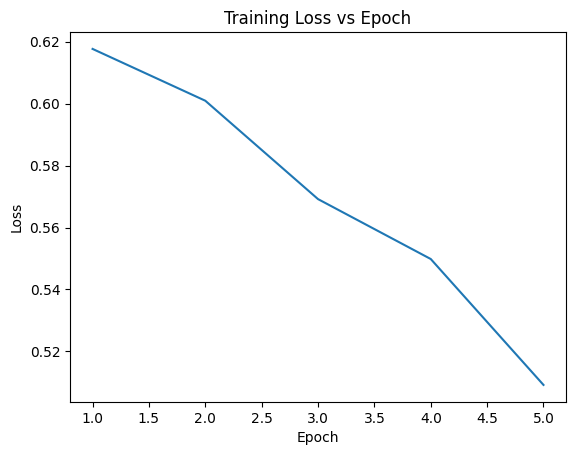

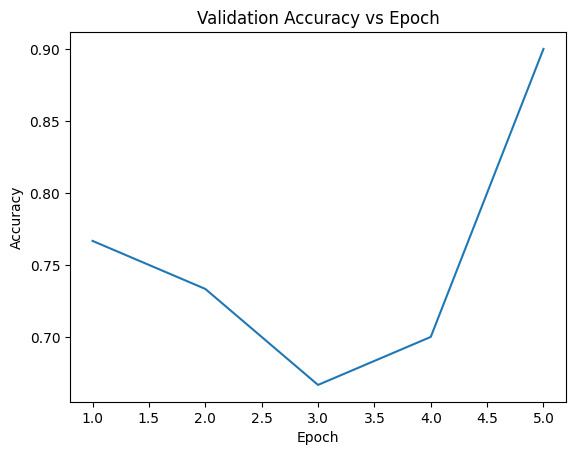

In [108]:
epochs_range = range(1, len(train_losses) + 1)

# Training Loss Graph   
plt.figure()
plt.plot(epochs_range, train_losses)
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Validation Accuracy Graph
plt.figure()
plt.plot(epochs_range, val_accuracies)
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Find the Best Model

In [109]:
import pandas as pd

results_df = pd.DataFrame(results, columns=["Model", "LR", "Optimizer", "Test Accuracy"]).sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

print("\nRESULTS:\n")
print(results_df)

print("\nBest Test Accuracy:", best_global_acc)


RESULTS:

           Model      LR Optimizer  Test Accuracy
0      mobilenet  0.0001      adam       1.000000
1   efficientnet  0.0001      adam       0.966667
2       resnet50  0.0001      adam       0.966667
3       resnet50  0.0010       sgd       0.966667
4          vgg19  0.0001       sgd       0.966667
5   efficientnet  0.0010      adam       0.966667
6   efficientnet  0.0010       sgd       0.966667
7          vgg19  0.0001      adam       0.933333
8      mobilenet  0.0010       sgd       0.933333
9          vgg16  0.0001      adam       0.933333
10         vgg16  0.0010       sgd       0.900000
11         vgg16  0.0001       sgd       0.900000
12     mobilenet  0.0010      adam       0.900000
13         vgg19  0.0010       sgd       0.900000
14     mobilenet  0.0001       sgd       0.866667
15  efficientnet  0.0001       sgd       0.733333
16      resnet50  0.0001       sgd       0.700000
17         vgg16  0.0010      adam       0.500000
18      resnet50  0.0010      adam     

In [110]:
best_global_model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in testLoader:
        outputs = best_global_model(images)

        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.numpy())
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)

roc = roc_auc_score(all_labels, all_probs)
print("\nROC-AUC Score:", roc)


📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
 [[15  0]
 [ 0 15]]

ROC-AUC Score: 1.0


In [111]:
torch.save(best_global_model.state_dict(), "best_model.pth")
print("\nBest model saved as best_model.pth")


Best model saved as best_model.pth
